## 8-2. CAM, Grad-CAM용 모델 준비하기 (1) 데이터셋 준비하기

CAM(Class Activation Map) 은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 구성되어야 한다는 제약이 있습니다. 반면에 Grad-CAM은 이러한 제약이 없죠.

이번 시간에는 CAM과 Grad-CAM, 이 두 가지를 모두 구현해 보겠습니다.
우선 CAM을 위한 모델을 먼저 구성해 기본적인 CAM을 추출해보고, 이 모델에서 Grad-CAM을 활용해 다시 시각화 결과물을 추출하겠습니다. Grad-CAM은 모델의 구조에 제약이 없기 때문에 CAM에만 모델을 맞춰도 충분하기 때문입니다.

CAM은 클래스에 대한 활성화 정도를 나타낸 지도 입니다. 따라서 기본적으로 우리의 모델은 분류(classfication) 를 수행하는 모델이어야 합니다. 하지만 우리의 최종 목표는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교하는 것이므로 위치 정보가 기록된 데이터가 함께 있어야 합니다.

Tensorflow Datasets의 카탈로그에서 이러한 데이터를 확인할 수 있는데요. 여기서는 stanford_dogs 데이터셋을 사용하겠습니다. 이는 120 종의 개를 사진으로 판별하는 분류 문제 데이터셋으로, 라벨이 위치 정보인 바운딩 박스(bounding box) 정보를 포함하고 있습니다. 그럼 필요한 라이브러리와 데이터셋을 준비하고 시작하겠습니다.

In [24]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print(np.__version__)

print("슝=3")


1.26.4
슝=3


In [25]:
tf.config.list_physical_devices("GPU")


[]

In [26]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.
(ds_train, ds_test), ds_info = tfds.load(
    "stanford_dogs",
    split=["train", "test"],
    shuffle_files=True,
    with_info=True,
)
print("슝=3")


슝=3


train data set


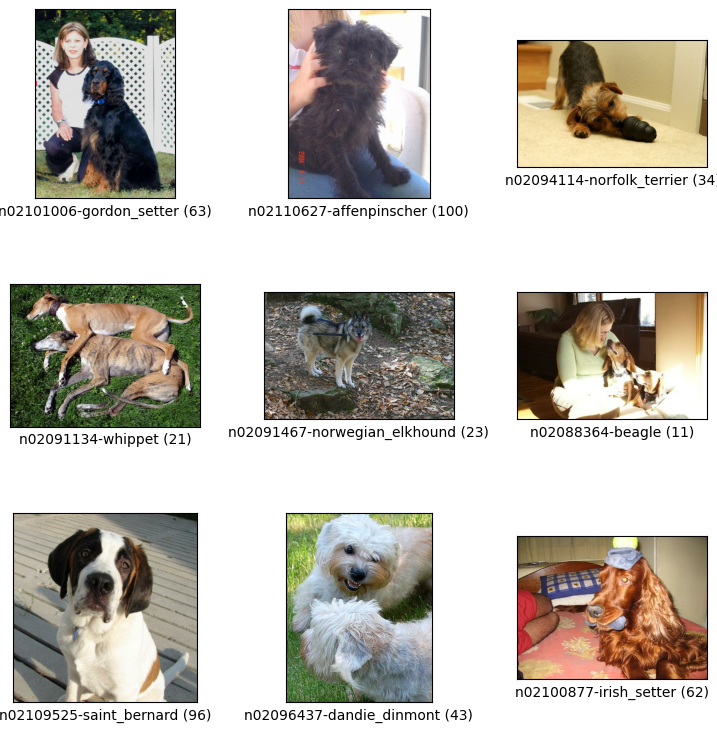

test data set


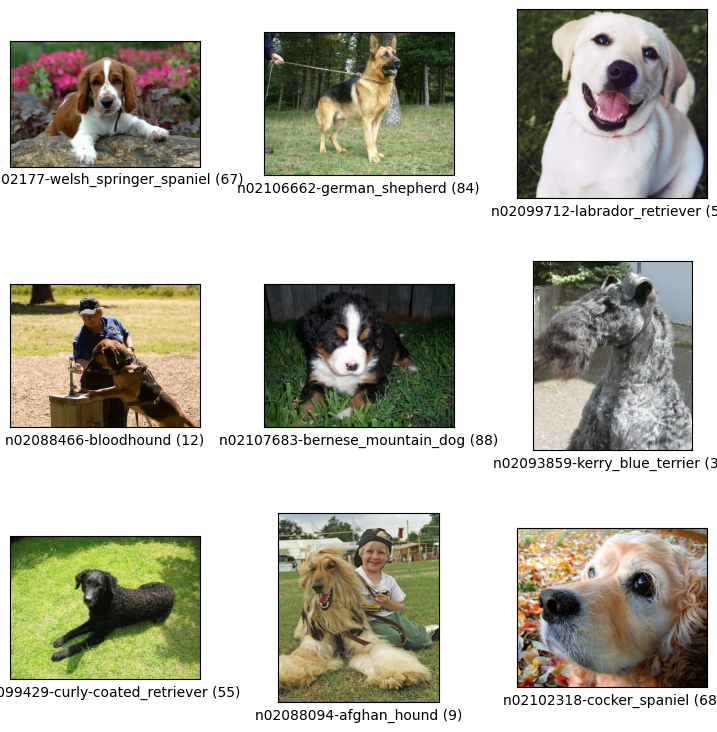

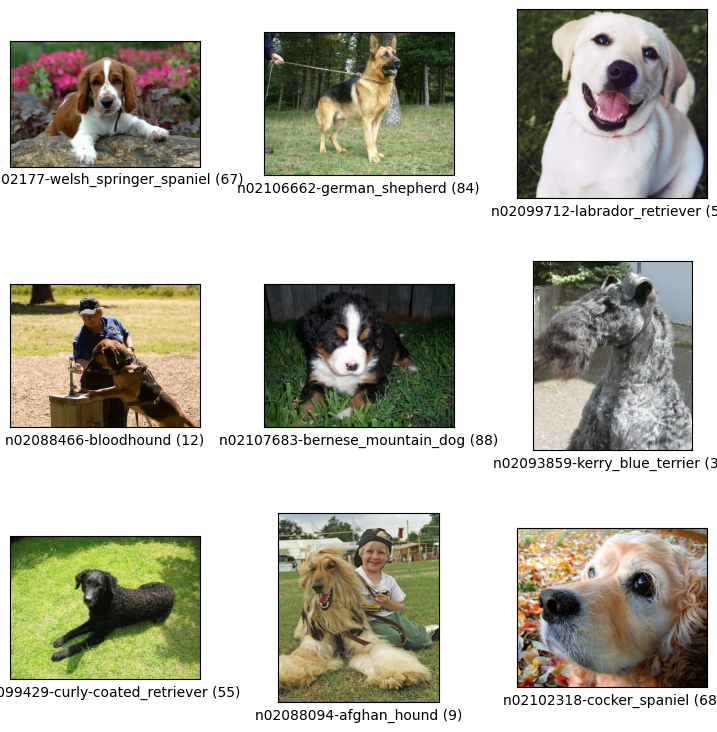

In [27]:
print('train data set')
tfds.show_examples(ds_train, ds_info)
# ds_train
print('test data set')
tfds.show_examples(ds_test, ds_info)


In [28]:
ds_info.features


FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})

먼저 image와 label은 입력 이미지와 이미지에 해당하는 정답 클래스의 인덱스입니다. 몇 번 보신 적 있으신가요? 그런데 조금 새로운 키(key)가 있습니다. bbox는 무엇일까요? bbox(바운딩 박스)는 아래 그림과 같이 물체의 위치를 사각형 영역으로 표기하는 방법입니다. 위에서 확인한 바로는 BBoxFeature이라는 타입으로 정의되어 있습니다.

바운딩 박스를 라벨링하는 방법은 아주 다양합니다. 그 중 주로 사용되는 방법은 'xywh' 또는 'minmax'로 표기하는 방법입니다.

'xywh' 는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법입니다.
(예) (x_center, y_center, width, height)
x, y가 중심점이 아니라 좌측 상단의 점을 가리킬 수도 있습니다.
'minmax'는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법입니다.
(예) (x_min, x_max, y_min, y_max)
좌표의 절대값이 아니라, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적입니다.
위 두가지 뿐만 아니라 이미지의 상하좌우 끝단으로부터 거리로 표현하는 방법, 좌우측의 x값과 상하측의 y값 네 개로 표시하는 방법(LRTB), 네 점의 x, y 좌표 값을 모두 표시하는 방법(QUAD) 등 여러 가지 방법이 있습니다. 따라서 새로운 데이터셋을 접하거나 라이브러리를 활용하실 때는 간단한 바운딩 박스 정보라도 한 번 더 표기법을 확인하고 넘어가는 것이 좋습니다.

## 8-4. CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기
이번에는 본격적으로 CAM을 얻어내기 위한 모델을 만들어 보겠습니다. 미리 이미지넷(ImageNet) 데이터에 훈련된 ResNet50을 기반으로 하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만들겠습니다.

참고로, 소프트맥스 레이어는 소프트맥스 함수를 활성화 함수로 사용하는 fully connected 레이어입니다.

In [29]:
num_classes = ds_info.features["label"].num_classes

base_model = keras.applications.resnet50.ResNet50(
    include_top=False,  # Imagenet 분류기  fully connected layer 제거
    weights="imagenet",
    input_shape=(224, 224, 3),
    pooling="avg",  # GAP를 적용
)
x = base_model.output

preds = keras.layers.Dense(num_classes, activation="softmax")(x)

cam_model = keras.Model(inputs=base_model.input, outputs=preds)
cam_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,833,592 (90.92 MB)

 Trainable params: 23,780,472 (90.72 MB)

 Non-trainable params: 53,120 (207.50 KB)

## 8-5. CAM, Grad-CAM용 모델 준비하기 (4) CAM 모델 학습하기

이제 학습을 위한 과정은 이전과 비슷합니다.

학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 normalize_and_resize_img() 에서 수행하며, 이를 포함하여 apply_normalize_on_dataset()에서 batch를 구성합니다.

input에 이전과 다르게 bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img과정에서 제외해 주었습니다. CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문입니다.

In [30]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input["image"], [224, 224])
    input["image"] = tf.cast(image, tf.float32) / 255.0
    return input["image"], input["label"]


def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    ds = ds.batch(batch_size)
    """
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    """
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


print("슝=3")

# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다.
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

cam_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

print("슝=3")

history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits["train"].num_examples / 16),
    validation_steps=int(ds_info.splits["test"].num_examples / 16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
)


슝=3
(16, 224, 224, 3)
(16,)
슝=3
Epoch 1/2
750/750 ━━━━━━━━━━━━━━━━━━━━ 2403s 3s/step - accuracy: 0.2911 - loss: 3.1401 - val_accuracy: 0.2000 - val_loss: 3.3386
Epoch 2/2


C:\Users\thilllon\.pyenv\pyenv-win\versions\3.10.11\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 2.1886


## 8-6. CAM

이제 학습된 모델을 활용하여 CAM을 생성해 볼 것입니다. 메모리 부족으로 인해 이후 실습에 문제가 발생할 수 있으므로, 이번 스텝 시작 전에 커널을 재시작할 것을 권합니다.






In [34]:
# 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    "stanford_dogs",
    split=["train", "test"],
    shuffle_files=True,
    with_info=True,
)


def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input["image"], [224, 224])
    input["image"] = tf.cast(image, tf.float32) / 255.0
    return input["image"], input["label"]


def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    ds = ds.batch(batch_size)
    """
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    """
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


print("슝=3")


슝=3


슝=3
108


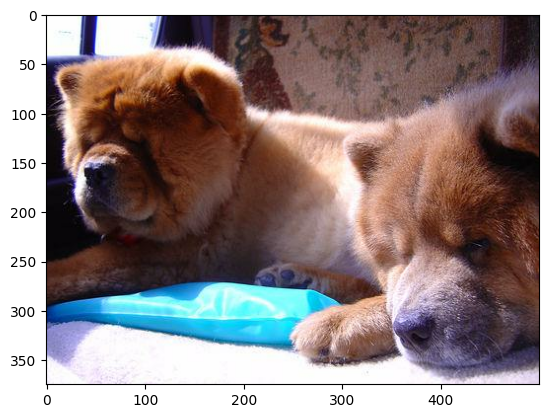

In [35]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]["objects"]["bbox"]
    image = sample_data[0]["image"]
    label = sample_data[0]["label"]
    return sample_data[0]


print("슝=3")

item = get_one(ds_test)
print(item["label"])
plt.imshow(item["image"])
plt.show()


In [36]:
import os

cam_model_path = os.getenv("HOME") + "/aiffel/class_activation_map/cam_model1.h5"
cam_model = tf.keras.models.load_model(cam_model_path)
print("슝=3")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'C:\Users\thilllon/aiffel/class_activation_map/cam_model1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [37]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

print('슝=3')


슝=3


## 8-7. Grad-CAM

이번에는 Grad-CAM을 이용해서 CAM을 얻어보도록 하겠습니다. 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 cam_model을 그대로 활용합시다.



67


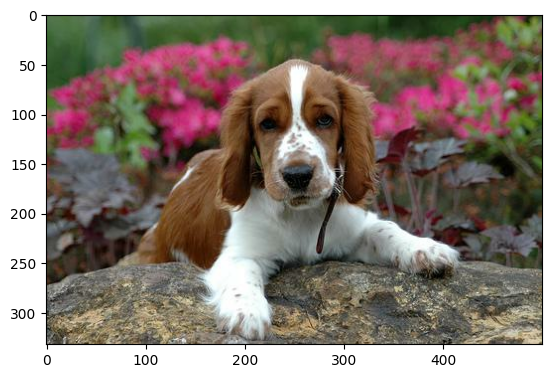

In [39]:
item = get_one(ds_test)
print(item["label"])
plt.imshow(item["image"])
plt.show()


이번에는 Grad-CAM을 이용해서 CAM을 만들어 봅시다.

grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 됩니다.

이전 스텝에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 합니다.

아래 generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용합니다.

In [40]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item["image"].shape[1]
    height = item["image"].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)

    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(activation_layer).output, model.output]
    )

    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))

        loss = pred[
            :, class_idx
        ]  # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0]  # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[
            0
        ]  # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1))  # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]

    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


print("슝=3")


슝=3


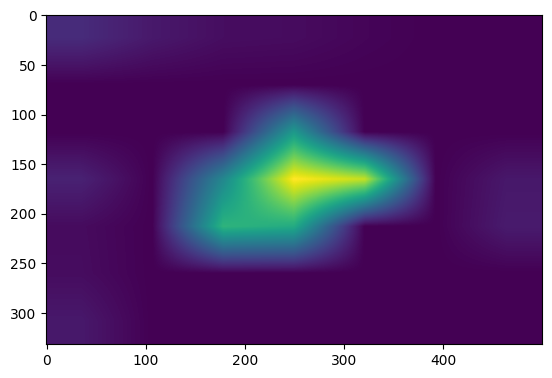

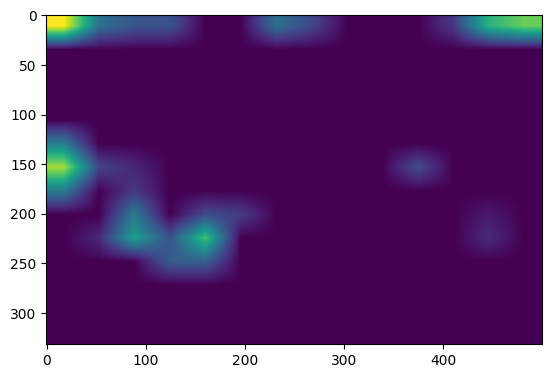

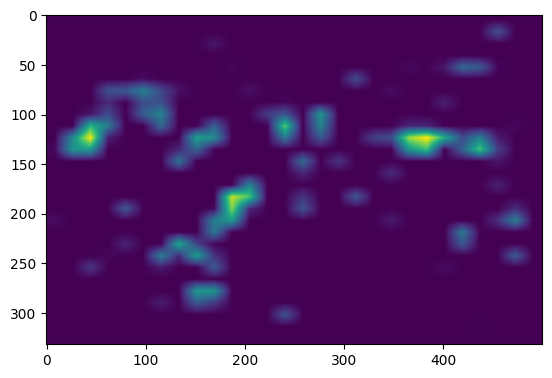

In [41]:
grad_cam_image = generate_grad_cam(cam_model, "conv5_block3_out", item)
plt.imshow(grad_cam_image)
plt.show()

grad_cam_image = generate_grad_cam(cam_model, "conv4_block3_out", item)
plt.imshow(grad_cam_image)
plt.show()

grad_cam_image = generate_grad_cam(cam_model, "conv3_block3_out", item)
plt.imshow(grad_cam_image)
plt.show()


## 8-8. Detection with CAM

바운딩 박스
마지막으로 이번에는 CAM에서 물체의 위치를 찾는 detection을 해 보도록 하겠습니다.

우선 새로운 이미지를 다시 뽑아 CAM 이미지를 뽑아봅시다.

108


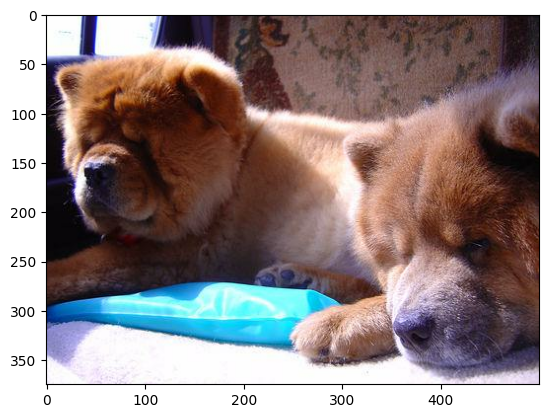

In [42]:
item = get_one(ds_test)
print(item["label"])
plt.imshow(item["image"])
plt.show()


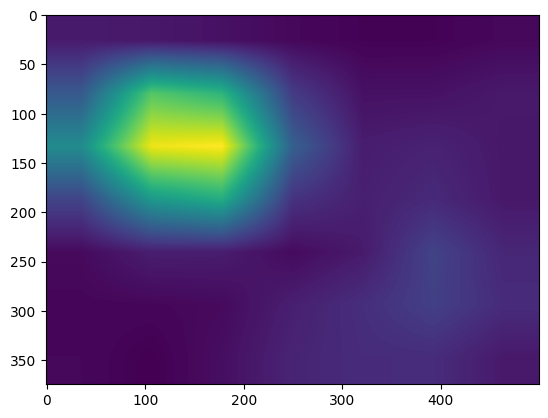

슝=3


C:\Users\thilllon\AppData\Local\Temp\ipykernel_25608\1182803837.py:15: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect = np.int0(rect)


array([[-58, 324],
       [  1,  -6],
       [543,  91],
       [484, 421]], dtype=int64)

In [43]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()


def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image * 255).astype(np.uint8)

    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect


print("슝=3")


rect = get_bbox(cam_image)
rect


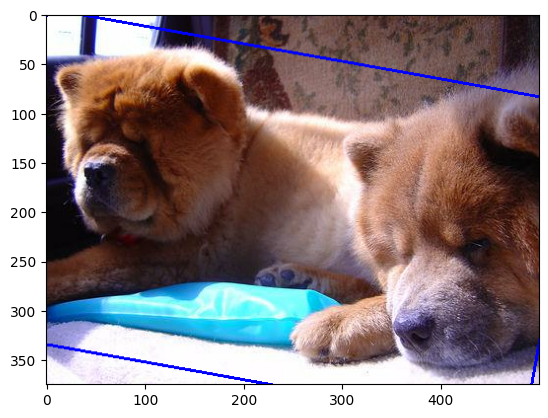

In [44]:
image = copy.deepcopy(item["image"])
image = cv2.drawContours(image, [rect], 0, (0, 0, 255), 2)
plt.imshow(image)
plt.show()


In [47]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다.
def rect_to_minmax(rect, image):
    bbox = [
        rect[:, 1].min() / float(image.shape[0]),  # bounding box의 y_min
        rect[:, 0].min() / float(image.shape[1]),  # bounding box의 x_min
        rect[:, 1].max() / float(image.shape[0]),  # bounding box의 y_max
        rect[:, 0].max() / float(image.shape[1]),  # bounding box의 x_max
    ]
    return bbox


print("슝=3")


슝=3


In [48]:
pred_bbox = rect_to_minmax(rect, item["image"])
pred_bbox


[-0.016, -0.116, 1.1226666666666667, 1.086]

In [49]:
item["objects"]["bbox"]


array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

In [50]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min = max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])

    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou


print("슝=3")


슝=3


In [51]:
get_iou(pred_bbox, item["objects"]["bbox"][0])


0.31101558515023253